# **Installation**

In [168]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scipy.stats import norm
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Range1d
from bokeh.palettes import viridis, cividis
from bokeh.layouts import row
from bokeh.layouts import gridplot
from bokeh.io import export_svgs
viridis_palette = viridis(256)



import optuna
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score

import lazypredict
from lazypredict.Supervised import LazyRegressor

# **Data Import**

In [169]:
# Create a DataFrame from CSV data
df = pd.read_csv("strokes.csv")

# **Feature Engineering**

In [170]:
selected_columns = ['player_id', 'last_name', 'round','hole','hole_score','par_value','yardage', 'shot', 'shot_type', 'num_of_strokes',
       'from_location_scorer', 'from_location_laser', 'to_location_scorer',
       'to_location_laser', 'distance', 'distance_to_pin', 'in_the_hole',
       'around_the_green', 'first_putt', 'dist_to_hole_after_shot', 'time',
       'lie', 'elevation', 'slope', 'x', 'y', 'z', 'dist_from_center',
       'dist_from_edge']  # Add the column names you want to select
df = df[selected_columns].copy()

#inches to yards
df['distance_to_pin'] = df['distance_to_pin']/36

df['dist_to_hole_after_shot'] = df['dist_to_hole_after_shot']/36


In [171]:
df['lie_location'] =    np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',
                        np.where(df['to_location_laser'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Bunker', case=False), 'Bunker',
                        np.where(df['to_location_scorer'].str.contains('Green', case=False), 'Green',
                        np.where(df['to_location_laser'].str.contains('Fairway', case=False), 'Fairway',
                        np.where(df['to_location_scorer'].str.contains('Tree', case=False), 'Rough',
                        #np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',
                        #distance_to_hole_after_the_shot == 0 ~ 'Hole',
                        np.where(df['to_location_scorer'].str.contains('Water', case=False), 'Water', 'Unknown'))))))))

# df = df[df['lie_location'] != 'Unknown']
df['round_hole_combination'] = (df['round'] - 1) * 18 + df['hole']

df['strokes_to_hole_out'] = df['hole_score'] - df['shot'] +1 
#instead of 1, should be df['num_of_strokes']
#then shots after water mark as provisionals
#drop shots from water
#plot a out a water penalty hole just to check

# **Drop Holes with Penalties**

- Figure out how to use the 400 discarded rows in the future

In [172]:
df['flag_strokes_to_hole_out_1_or_less'] = df['strokes_to_hole_out'] <= 0

selected_rows = df[df['flag_strokes_to_hole_out_1_or_less']]

# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
result_df = df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
result_df = result_df[result_df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

# **Drop Holes with Water or Unknown Lies**

In [173]:
result_df['flag_water_or_unknown_lies'] = (result_df['lie_location'] == 'Water') | (result_df['lie_location'] == 'Unknown')

selected_rows = result_df[result_df['flag_water_or_unknown_lies']]

# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
result_df = result_df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
result_df = result_df[result_df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

# **Drop Holes with Non Standards Shot Types**

In [174]:
result_df['flag_non_standard_shot_types'] = result_df['shot_type'] != 'S'

selected_rows = result_df[result_df['flag_non_standard_shot_types']]

#-----

# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
result_df = result_df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
result_df = result_df[result_df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

In [175]:
# Shift all values in the 'column_name' down by one row
result_df['lie_location'] = result_df['lie_location'].shift(1)

result_df['lie_location'] =    np.where(result_df['shot'] == 1, 'Tee',result_df['lie_location'])

#sanity check tee looks good
#result_df[['last_name', 'round_hole_combination','shot', 'hole_score','strokes_to_hole_out','distance_to_pin','lie_location','first_putt']].iloc[:10]

# sanity check making sure no chip ins

# idx = result_df.groupby('round_hole_combination')['shot'].idxmax()

# result_df[['distance_to_pin','lie_location','first_putt','to_location_laser','to_location_scorer']].loc[idx].iloc[:30]


In [176]:
result_df.to_csv('FE_golf.csv')

# **Distance to Pin vs Strokes to Hole Out**

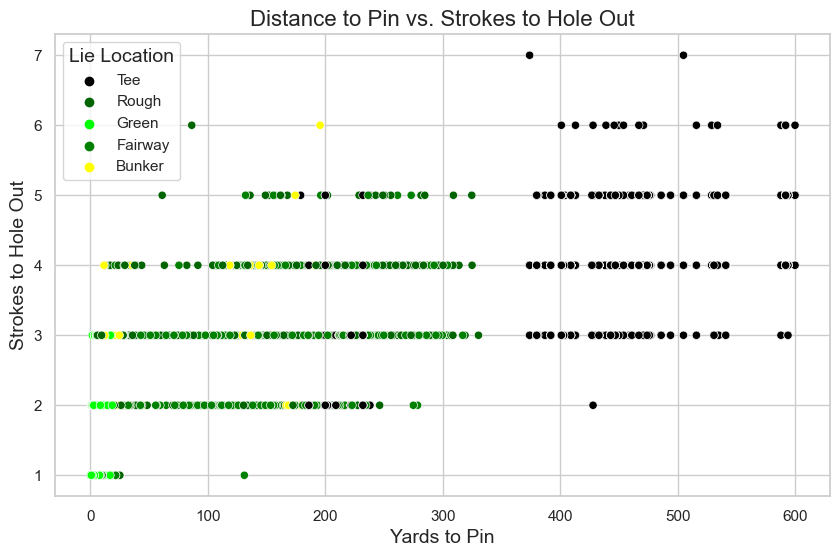

In [177]:
# Define a color palette
pal = {
    'Rough': '#006400',
    'Green': '#00FF00',
    'Fairway': '#008000',
    'Bunker': 'yellow',
    'Tee': 'black'
}

# Set Seaborn style
sns.set(style='whitegrid')

# Create scatter plot with improved aesthetics
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x='distance_to_pin', y='strokes_to_hole_out', hue='lie_location', palette=pal, data=result_df)

# Set plot title and labels
plt.title('Distance to Pin vs. Strokes to Hole Out', fontsize=16)
plt.xlabel('Yards to Pin', fontsize=14)
plt.ylabel('Strokes to Hole Out', fontsize=14)

# Customize legend
scatter_plot.legend(title='Lie Location', title_fontsize='14', loc='upper left')

# Show the plot
plt.show()

# **Bin Distances to Pin**

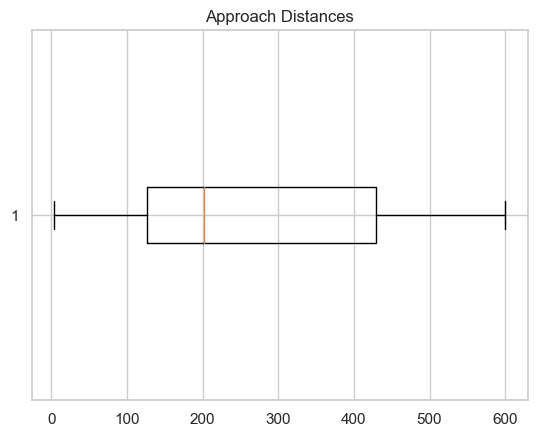

In [178]:
non_green_df = result_df[result_df['lie_location'] != 'Green']
plt.title('Approach Distances')
plt.boxplot(non_green_df['distance_to_pin'], vert=False)
plt.show()

In [179]:
# bins = list(range(0, 700, 100))  # Creates bins from 0 to 600 with intervals of 10
# labels = [f'{i}-{i+100}' for i in range(0, 600, 100)]  # Creates labels for each bin

# Assuming result_df is your DataFrame
bins =    [0,       100,       150,       200,       250,       300,       450, 600]
labels = ['0-100', '100-150', '150-200', '200-250', '250-300', '300-450', '450-650']

result_df['distance_bins'] = pd.cut(result_df['distance_to_pin'], bins=bins, labels=labels, right=False)
print(result_df['distance_bins'].isna().sum())
result_df['distance_bins'] = result_df['distance_bins'].cat.add_categories([''])
result_df['distance_bins'].fillna('', inplace=True)
print(result_df['distance_bins'].isna().sum())



28
0


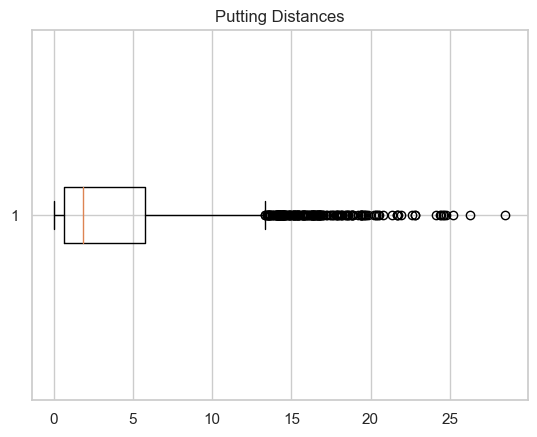

In [180]:
green_df = result_df[result_df['lie_location'] == 'Green']
plt.title('Putting Distances')
plt.boxplot(green_df['distance_to_pin'], vert=False)
plt.show()

In [181]:
bins =    [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 14, 30]
labels = ['0-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3-3.5', '3.5-4', '4-5', '5-6', '6-14', '14-30']

result_df['distance_bins_putting'] = pd.cut(result_df['distance_to_pin'], bins=bins, labels=labels, right=False)
print(result_df['distance_bins_putting'].isna().sum())
result_df['distance_bins_putting'] = result_df['distance_bins_putting'].cat.add_categories([''])
result_df['distance_bins_putting'].fillna('', inplace=True)
print(result_df['distance_bins_putting'].isna().sum())



3932
0


# **TODO**

# **Above worked great, so bin:**

# **dis to edge for putting**

In [182]:
#TODO

 # **dist to center for approach**

In [183]:
#TODO

# **Lazy Predict**

In [184]:
# numeric_features = ['distance_to_pin',"dist_from_center"]
# numeric_transformer = Pipeline(steps=[
#     ("scaler", RobustScaler())
# ])

# categorical_features = ["lie_location",'round','par_value','slope','elevation','lie']
# categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# preprocessor = ColumnTransformer(transformers=[
#     ("num_transform", numeric_transformer, numeric_features),
#     ("cat_transform", categorical_transformer, categorical_features)
# ])

In [185]:
# feature_cols = ["lie_location",'round','par_value','slope','elevation','lie','distance_to_pin',"dist_from_center"]
# X = result_df.loc[:, feature_cols]

# target_cols = ['strokes_to_hole_out']
# y = result_df.loc[:, target_cols]

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05,random_state=42,stratify = X[['lie_location',"par_value"]])

In [186]:
# reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )

# models,predictions = reg.fit(X_train, X_valid, y_train.values.ravel(), y_valid.values.ravel())

In [187]:
# models

In [188]:
# predictions

# **Optuna**

Do this again once done with binning...

In [189]:
# feature_cols = ["lie_location",'round','par_value','slope','elevation','lie','distance_to_pin',"dist_from_center"]
# X = result_df.loc[:, feature_cols]

# categorical_cols = ["lie_location",'round','par_value','slope','elevation','lie']
# X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# target_cols = ['strokes_to_hole_out'] 
# y = result_df.loc[:, target_cols]

# # Extract the columns for stratification
# stratify_cols = ["lie_location", "par_value"]
# stratify_data = result_df[stratify_cols]

# # Split the data, using 'stratify_data' for stratification
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_data)

# GradientBoostingRegressor

In [190]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_uniform("max_features", 0.1, 1.0),
#     }

#     model = GradientBoostingRegressor(**params, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


# LGBMRegressor

In [191]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
#         "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
#     }

#     model = LGBMRegressor(**params, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))

# AdaBoostRegressor

In [192]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 1.0),
#         # Add any other relevant hyperparameters for AdaBoostRegressor
#     }

#     model = AdaBoostRegressor(**params, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


# RandomForestRegressor

In [193]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "max_depth": trial.suggest_int("max_depth", 3, 20),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_uniform("max_features", 0.1, 1.0),
#     }

#     model = RandomForestRegressor(**params, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))

# MLPRegressor

In [194]:
# def objective(trial):
#     params = {
#         "hidden_layer_sizes": trial.suggest_int("hidden_layer_sizes", 1, 100),
#         "alpha": trial.suggest_loguniform("alpha", 1e-6, 1.0),
#         "learning_rate_init": trial.suggest_loguniform("learning_rate_init", 1e-5, 1e-1),
#         "max_iter": trial.suggest_int("max_iter", 100, 1000),
#     }

#     model = MLPRegressor(**params, random_state=42)

#     model.fit(X_train, y_train.values.ravel())  # Note: MLPRegressor expects a 1D array for the target variable
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


# Optuna for Final Estimator's Meta Model

In [195]:
# # Assuming you have X_train, X_valid, y_train, y_valid defined

# # Define your base models
# base_models = [
#     ("GradientBoostingRegressor_pipeline", GradientBoostingRegressor(
#         n_estimators=298,
#         learning_rate= 0.017565096916826627,
#         max_depth= 4,
#         subsample= 0.9480233926615609,
#         min_samples_split= 9,
#         min_samples_leaf= 3,
#         max_features= 0.8625158448136574
#     )),
#     ("LGBMRegressor_pipeline", LGBMRegressor(
#         n_estimators= 442,
#         learning_rate= 0.009437712702673798,
#         max_depth= 4,
#         subsample= 0.6659162524367865,
#         colsample_bytree= 0.7446478198020141,
#         min_child_samples= 6,
#         reg_alpha= 6.32482216734694e-05,
#         reg_lambda= 0.001956292371616008)),
#     ("AdaBoostRegressor_pipeline", AdaBoostRegressor( 
#         n_estimators= 498,
#         learning_rate= 0.013946367159574381)),
#     ("RandomForestRegressor_pipeline", RandomForestRegressor(
#             n_estimators= 347,
#             max_depth= 7,
#             min_samples_split= 10,
#             min_samples_leaf= 7,
#             max_features= 0.5624136409317273)),
#     ("MLPRegressor_pipeline", MLPRegressor(
#       hidden_layer_sizes= 61,
#       alpha= 0.0016007134120975964,
#       learning_rate_init= 0.0002972290214448905,
#       max_iter= 226))
# ]

# # Create the stack model with fixed base models
# stack_model = StackingRegressor(estimators=base_models, final_estimator=GradientBoostingRegressor())

# def objective(trial):
#     # Define hyperparameters for the final estimator (meta-model)
#     meta_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_uniform("max_features", 0.1, 1.0)
#     }

#     # Create a new instance of GradientBoostingRegressor with tuned hyperparameters
#     final_estimator = GradientBoostingRegressor(**meta_params)

#     # Set the new final estimator in the stack model
#     stack_model.final_estimator = final_estimator

#     # Fit the stack model on the training data
#     stack_model.fit(X_train, y_train.values.ravel())

#     # Make predictions on the validation data
#     preds = stack_model.predict(X_valid)

#     # Evaluate the model using mean squared error
#     mse = mean_squared_error(y_valid, preds)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


# #result:
# '''
# Best trial:
#   Value: 0.1813
#   Params: 
#     n_estimators: 273
#     learning_rate: 0.03887266282764213
#     max_depth: 3
#     subsample: 0.81654345269596
#     min_samples_split: 7
#     min_samples_leaf: 10
#     max_features: 0.5767799915192618
# '''


# **SG Stack Putting Model**

In [196]:
result_df

,player_id,last_name,round,hole,hole_score,par_value,yardage,shot,shot_type,num_of_strokes,...,dist_from_center,dist_from_edge,lie_location,round_hole_combination,strokes_to_hole_out,flag_strokes_to_hole_out_1_or_less,flag_water_or_unknown_lies,flag_non_standard_shot_types,distance_bins,distance_bins_putting
0,1810,Mickelson,1,1,4,4,424,1,S,1,...,562,126,Tee,1,4,False,False,False,300-450,
1,1810,Mickelson,1,1,4,4,424,2,S,1,...,232,25,Rough,1,3,False,False,False,100-150,
2,1810,Mickelson,1,1,4,4,424,3,S,1,...,33,199,Green,1,2,False,False,False,0-100,6-14
3,1810,Mickelson,1,1,4,4,424,4,S,1,...,0,0,Green,1,1,False,False,False,0-100,1-1.5
4,1810,Mickelson,1,2,2,3,214,1,S,1,...,214,347,Tee,2,2,False,False,False,200-250,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8062,33141,Bradley,4,17,5,4,470,4,S,1,...,61,95,Green,71,2,False,False,False,0-100,14-30
8063,33141,Bradley,4,17,5,4,470,5,S,1,...,0,0,Green,71,1,False,False,False,0-100,1.5-2
8064,33141,Bradley,4,18,3,3,235,1,S,1,...,296,294,Tee,72,3,False,False,False,200-250,
8065,33141,Bradley,4,18,3,3,235,2,S,1,...,4,184,Green,72,2,False,False,False,0-100,6-14


In [197]:
putting_numeric_features = ['distance_to_pin','dist_from_edge']
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])

putting_categorical_features = ['slope','elevation','distance_bins_putting']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

putting_preprocessor = ColumnTransformer(transformers=[
    ("num_transform", numeric_transformer, putting_numeric_features),
    ("cat_transform", categorical_transformer, putting_categorical_features)
])

green_df = result_df[result_df['lie_location'] == 'Green']

feature_cols = ['slope','elevation','distance_to_pin','distance_bins_putting','dist_from_edge']
X = green_df.loc[:, feature_cols]

target_cols = ['strokes_to_hole_out']
y = green_df.loc[:, target_cols]

putting_X_train, putting_X_valid, putting_y_train, putting_y_valid = train_test_split(X, y, train_size=0.85, test_size=0.15,random_state=42,stratify = X[['distance_bins_putting']])

In [198]:
# feature_cols = ['slope','elevation','distance_to_pin']
# X = green_df.loc[:, feature_cols]

# categorical_cols = ['slope','elevation']
# X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# target_cols = ['strokes_to_hole_out'] 
# y = green_df.loc[:, target_cols]

# # Extract the columns for stratification
# stratify_cols = ['slope','elevation']
# stratify_data = green_df[stratify_cols]

# # Split the data, using 'stratify_data' for stratification
# putting_X_train, putting_X_valid, putting_y_train, putting_y_valid  = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_data)

In [199]:
#Putting Putting Putting

#1
GradientBoostingRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", putting_preprocessor), 
    ("GradientBoostingRegressor_pipeline", GradientBoostingRegressor(
        n_estimators=286,
        learning_rate= 0.01981634618847298,
        max_depth= 5,
        subsample= 0.9240470863832018,
        min_samples_split= 10,
        min_samples_leaf= 1,
        max_features= 0.6070414161555119
    ))])

#2

#Optuna Results
LGBMRegressor_pipeline = Pipeline(steps=[
    ("preprocessor", putting_preprocessor), 
    ("LGBMRegressor_pipeline", LGBMRegressor(
        n_estimators=463,
        learning_rate=0.09827919329551392,
        max_depth=5,
        subsample=0.5856953536670598,
        colsample_bytree=0.9504918763968095,
        min_child_samples=6,
        reg_alpha=5.070474210480463,
        reg_lambda=1.9254404262179434e-06
    ))
])

#Optuna Results
AdaBoostRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", putting_preprocessor), 
    ("AdaBoostRegressor_pipeline", AdaBoostRegressor( 
        n_estimators= 246,
        learning_rate= 0.0024297994462212564))])

RandomForestRegressor_pipeline = Pipeline(steps=[
    ("preprocessor", putting_preprocessor), 
    ("RandomForestRegressor_pipeline", RandomForestRegressor(
        n_estimators=431,
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=1,
        max_features=0.7429990460692442
    ))
])

#6
MLPRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", putting_preprocessor), 
    ("MLPRegressor_pipeline", MLPRegressor(
      hidden_layer_sizes= 31,
      alpha= 0.007143767710608828,
      learning_rate_init= 0.09007633815423446,
      max_iter= 803
    ))])

In [200]:
# Define your base models
base_models = [('GradientBoostingRegressor_pipeline', GradientBoostingRegressor_pipeline),
               ('LGBMRegressor_pipeline',LGBMRegressor_pipeline),
               ('AdaBoostRegressor_pipeline', AdaBoostRegressor_pipeline),
               ('RandomForestRegressor_pipeline', RandomForestRegressor_pipeline),
               ('MLPRegressor_pipeline', MLPRegressor_pipeline)]

# Define the meta-model
meta_model = GradientBoostingRegressor(
        n_estimators=286,
        learning_rate= 0.01981634618847298,
        max_depth= 5,
        subsample= 0.9240470863832018,
        min_samples_split= 10,
        min_samples_leaf= 1,
        max_features= 0.6070414161555119
)

# Create the stack model
stack_model_putting = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Fit the stack model on the training data
stack_model_putting.fit(putting_X_train, putting_y_train.values.ravel())

# Make predictions on the validation data
preds = stack_model_putting.predict(putting_X_valid)

# Extract the predicted distances
predicted_distance = list(preds)
actual_distance = putting_y_valid['strokes_to_hole_out'].to_list()


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 2929, number of used features: 19
[LightGBM] [Info] Start training from score 1.418573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

**Residuals**

In [201]:
final_pipe_results = pd.DataFrame()

final_pipe_results['predicted_distance'] = predicted_distance

final_pipe_results['actual_distance'] = actual_distance

final_pipe_results['residual'] = final_pipe_results['actual_distance'] - final_pipe_results['predicted_distance']

p = figure(height=300, width=300,title="Predicted vs Actual")
p.circle(actual_distance, predicted_distance, size=5, line_color=viridis_palette[180], fill_color=viridis_palette[180], fill_alpha=0.3)
p.xaxis.axis_label = 'Actual'
p.yaxis.axis_label = 'Predicted'

z = figure(height=300, width=300,title="Predicted vs Residual")
z.circle(final_pipe_results.residual, final_pipe_results.predicted_distance, size=5, line_color=viridis_palette[180], fill_color=viridis_palette[180], fill_alpha=0.3)
z.yaxis.axis_label = 'Predicted'
z.xaxis.axis_label = 'Residual'

b = figure(width=600, height=300, toolbar_location=None,
           title="Normality of Residuals")

# Histogram
bins = np.linspace(-0.5, 0.5, 100)
hist, edges = np.histogram(final_pipe_results.residual, density=True, bins=bins)
b.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color=viridis_palette[180], line_color="white")

b.y_range.start = 0
b.x_range.start = -0.5
b.x_range.end = 0.5

b.xaxis.axis_label = "Residuals"
b.yaxis.axis_label = "Distribution Count"

grid = gridplot([[row(p,z)], 
                 [b]])
show(grid)

**[Permutaion Importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)**

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

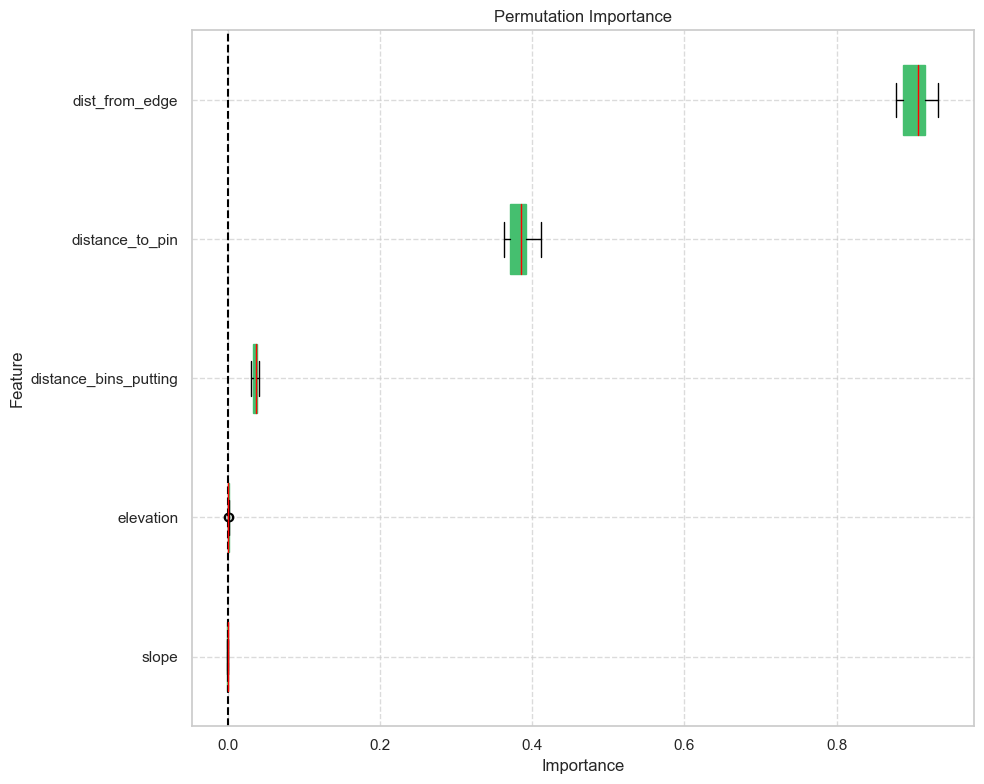

In [202]:
result = permutation_importance(stack_model_putting, 
                                putting_X_train, 
                                putting_y_train.values.ravel(), 
                                n_repeats=10,
                                random_state=42)

# Your existing code for permutation importance calculation

fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size for better readability and aesthetics

perm_sorted_idx = result.importances_mean.argsort()

# Customize boxplot appearance
box = ax.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    patch_artist=True,  # Enable filling colors
    boxprops=dict(facecolor=viridis_palette[180], color=viridis_palette[180]),  # Box color customization
    whiskerprops=dict(color='black'),  # Whisker color customization
    capprops=dict(color='black'),  # Cap color customization
    medianprops=dict(color='red')  # Median line color customization
)

# Set labels and title
ax.set_yticklabels(putting_X_train.columns[perm_sorted_idx])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Permutation Importance')

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line at x=0
ax.axvline(x=0, color="black", linestyle="--")

# Customize layout
plt.tight_layout()

plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

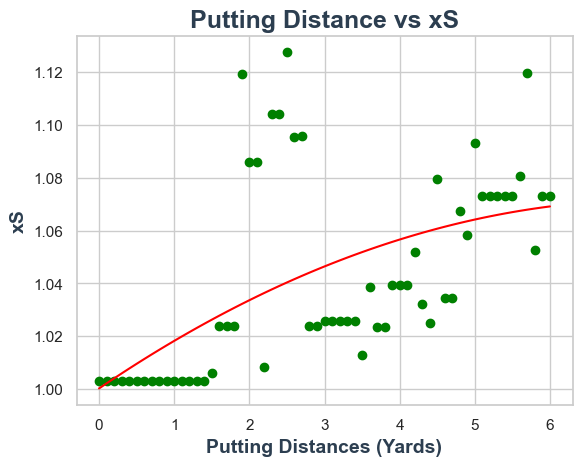

slope                    Level
elevation                 With
distance_to_pin           0.92
distance_bins_putting      0-1
dist_from_edge               0
Name: 4343, dtype: object

In [203]:
putting_test = putting_X_valid.iloc[9]

putting_Predictions = []
list_of_putting_distances = [round(x * 0.1, 1) for x in range(0, 61)]
f = putting_test
input = f.to_frame().T

for i in list_of_putting_distances:
    input['distance_to_pin'] = i
    preds = stack_model_putting.predict(input)
    putting_Predictions.append(preds[0])

plt.scatter(list_of_putting_distances, putting_Predictions, color='green', label='Scatter Plot')

coefficients = np.polyfit(list_of_putting_distances, putting_Predictions, 2)
poly_line = np.poly1d(coefficients)
plt.plot(list_of_putting_distances, poly_line(list_of_putting_distances), color='red', label='Best Fit Line')
plt.xlabel('Putting Distances (Yards)', fontsize=14, fontweight='bold', color='#2c3e50')  # Dark blue for the label
plt.ylabel('xS', fontsize=14, fontweight='bold', color='#2c3e50')
plt.title('Putting Distance vs xS', fontsize=18, fontweight='bold', color='#2c3e50')  # Larger title with dark blue color
plt.show()

putting_test

# **SG Stack *NON* Putting Model**

In [204]:
numeric_features = ['distance_to_pin','dist_from_center','dist_from_edge']
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])

categorical_features = ["lie_location",'round','par_value','slope','elevation', 'distance_bins']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(transformers=[
    ("num_transform", numeric_transformer, numeric_features),
    ("cat_transform", categorical_transformer, categorical_features)
])

result_df_no_green = result_df[result_df['lie_location'] != 'Green']


# took out 'hole'
feature_cols = ["lie_location",'round','par_value','slope','elevation','lie','distance_to_pin',"dist_from_center", 'distance_bins','dist_from_edge']
X = result_df_no_green.loc[:, feature_cols]

target_cols = ['strokes_to_hole_out']
y = result_df_no_green.loc[:, target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.85, test_size=0.15,random_state=42,stratify = X[['lie_location',"par_value"]])

In [205]:
#1

#Optuna Results:
'''
Best trial:
  Value: 0.1766
  Params: 
    n_estimators: 298
    learning_rate: 0.017565096916826627
    max_depth: 4
    subsample: 0.9480233926615609
    min_samples_split: 9
    min_samples_leaf: 3
    max_features: 0.8625158448136574
'''
GradientBoostingRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("GradientBoostingRegressor_pipeline", GradientBoostingRegressor(
        n_estimators=298,
        learning_rate= 0.017565096916826627,
        max_depth= 4,
        subsample= 0.9480233926615609,
        min_samples_split= 9,
        min_samples_leaf= 3,
        max_features= 0.8625158448136574
    ))])

#2

#Optuna Results
'''
Best trial:
  Value: 0.1772
  Params: 
    n_estimators: 442
    learning_rate: 0.009437712702673798
    max_depth: 4
    subsample: 0.6659162524367865
    colsample_bytree: 0.7446478198020141
    min_child_samples: 6
    reg_alpha: 6.32482216734694e-05
    reg_lambda: 0.001956292371616008
'''
LGBMRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("LGBMRegressor_pipeline", LGBMRegressor(
        n_estimators= 442,
        learning_rate= 0.009437712702673798,
        max_depth= 4,
        subsample= 0.6659162524367865,
        colsample_bytree= 0.7446478198020141,
        min_child_samples= 6,
        reg_alpha= 6.32482216734694e-05,
        reg_lambda= 0.001956292371616008))])

#Optuna Results
'''
Best trial:
  Value: 0.1901
  Params: 
    n_estimators: 498
    learning_rate: 0.013946367159574381
'''
AdaBoostRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("AdaBoostRegressor_pipeline", AdaBoostRegressor( 
        n_estimators= 498,
        learning_rate= 0.013946367159574381))])

#5

#Optuna Results
'''
Best trial:
  Value: 0.1767
  Params: 
    n_estimators: 347
    max_depth: 7
    min_samples_split: 10
    min_samples_leaf: 7
    max_features: 0.5624136409317273
'''
RandomForestRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("RandomForestRegressor_pipeline", RandomForestRegressor(
            n_estimators= 347,
            max_depth= 7,
            min_samples_split= 10,
            min_samples_leaf= 7,
            max_features= 0.5624136409317273
    ))])

#6

#Optuna Results
'''
Best trial:
  Value: 0.1900
  Params: 
    hidden_layer_sizes: 61
    alpha: 0.0016007134120975964
    learning_rate_init: 0.0002972290214448905
    max_iter: 226
'''
MLPRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("MLPRegressor_pipeline", MLPRegressor(
      hidden_layer_sizes= 61,
      alpha= 0.0016007134120975964,
      learning_rate_init= 0.0002972290214448905,
      max_iter= 226
    ))])

In [206]:
# Define your base models
base_models = [('GradientBoostingRegressor_pipeline', GradientBoostingRegressor_pipeline),
               ('LGBMRegressor_pipeline',LGBMRegressor_pipeline),
            # idk why hist wants sparse data, no optuna for now
            # ('HistGradientBoostingRegressor_pipeline', HistGradientBoostingRegressor_pipeline),
               ('AdaBoostRegressor_pipeline', AdaBoostRegressor_pipeline),
               ('RandomForestRegressor_pipeline', RandomForestRegressor_pipeline),
               ('MLPRegressor_pipeline', MLPRegressor_pipeline)]

# Define the meta-model
meta_model = GradientBoostingRegressor(
    n_estimators= 273,
    learning_rate= 0.03887266282764213,
    max_depth= 3,
    subsample= 0.81654345269596,
    min_samples_split= 7,
    min_samples_leaf= 10,
    max_features= 0.5767799915192618
)

# Create the stack model
stack_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Fit the stack model on the training data
stack_model.fit(X_train, y_train.values.ravel())

# Make predictions on the validation data
preds = stack_model.predict(X_valid)

# Extract the predicted distances
predicted_distance = list(preds)
actual_distance = y_valid['strokes_to_hole_out'].to_list()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 3927, number of used features: 28
[LightGBM] [Info] Start training from score 3.303540
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

**Residuals**

In [207]:
final_pipe_results = pd.DataFrame()

final_pipe_results['predicted_distance'] = predicted_distance

final_pipe_results['actual_distance'] = actual_distance

final_pipe_results['residual'] = final_pipe_results['actual_distance'] - final_pipe_results['predicted_distance']

p = figure(height=300, width=300,title="Predicted vs Actual")
p.circle(actual_distance, predicted_distance, size=5, line_color=viridis_palette[180], fill_color=viridis_palette[180], fill_alpha=0.1)
p.xaxis.axis_label = 'Actual'
p.yaxis.axis_label = 'Predicted'

z = figure(height=300, width=300,title="Predicted vs Residual")
z.circle(final_pipe_results.residual, final_pipe_results.predicted_distance, size=5, line_color=viridis_palette[180], fill_color=viridis_palette[180], fill_alpha=0.1)
z.yaxis.axis_label = 'Predicted'
z.xaxis.axis_label = 'Residual'

b = figure(width=600, height=300, toolbar_location=None,
           title="Normality of Residuals")

# Histogram
bins = np.linspace(-2, 2, 80)
hist, edges = np.histogram(final_pipe_results.residual, density=True, bins=bins)
b.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color=viridis_palette[180], line_color="white")

b.y_range.start = 0
b.x_range.start = -2
b.x_range.end = 2

b.xaxis.axis_label = "Residuals"
b.yaxis.axis_label = "Distribution Count"

grid = gridplot([[row(p,z)], 
                 [b]])
show(grid)

**[Permutaion Importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)**

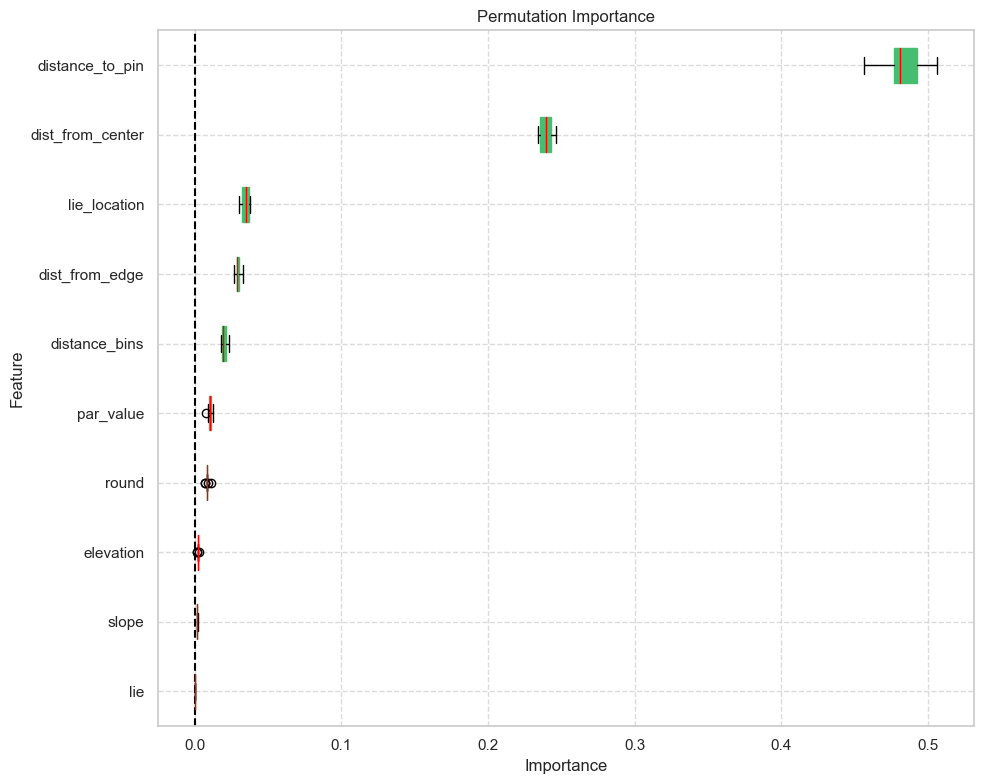

In [41]:
result = permutation_importance(stack_model, 
                                X_train, 
                                y_train.values.ravel(), 
                                n_repeats=10,
                                random_state=42)

# Your existing code for permutation importance calculation

fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size for better readability and aesthetics

perm_sorted_idx = result.importances_mean.argsort()

# Customize boxplot appearance
box = ax.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    patch_artist=True,  # Enable filling colors
    boxprops=dict(facecolor=viridis_palette[180], color=viridis_palette[180]),  # Box color customization
    whiskerprops=dict(color='black'),  # Whisker color customization
    capprops=dict(color='black'),  # Cap color customization
    medianprops=dict(color='red')  # Median line color customization
)

# Set labels and title
ax.set_yticklabels(X_train.columns[perm_sorted_idx])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Permutation Importance')

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add a vertical line at x=0
ax.axvline(x=0, color="black", linestyle="--")

# Customize layout
plt.tight_layout()

plt.show()


# **Predictions**

# Off the Tee

In [42]:
tee_data = X_valid.iloc[99]

Tee_Predictions = []
list_of_distances = [round(x, 1) for x in range(200, 600)]
list_of_distances_tee = list_of_distances
f = tee_data
input = f.to_frame().T

for i in list_of_distances:
    input['distance_to_pin'] = i
    preds = stack_model.predict(input)
    Tee_Predictions.append(preds[0])

tee_data

lie_location        Fairway
round                     4
par_value                 4
slope                 Level
elevation              With
lie                    Good
distance_to_pin       77.94
dist_from_center        143
distance_bins         0-100
dist_from_edge          804
Name: 6479, dtype: object

Text(0.5, 1.0, 'Off Tee xS vs Distance')

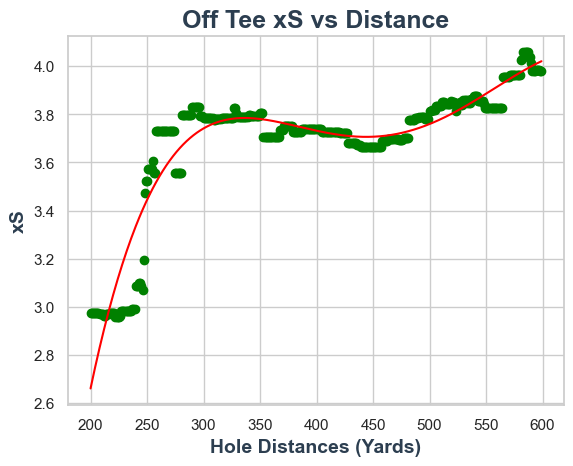

In [43]:
plt.scatter(list_of_distances, Tee_Predictions, color='green', label='Scatter Plot')

coefficients = np.polyfit(list_of_distances, Tee_Predictions, 4)
poly_line = np.poly1d(coefficients)
plt.plot(list_of_distances, poly_line(list_of_distances), color='red', label='Best Fit Line')
plt.xlabel('Hole Distances (Yards)', fontsize=14, fontweight='bold', color='#2c3e50')  # Dark blue for the label
plt.ylabel('xS', fontsize=14, fontweight='bold', color='#2c3e50')
plt.title('Off Tee xS vs Distance', fontsize=18, fontweight='bold', color='#2c3e50')  # Larger title with dark blue color

# Approach xS

In [44]:
approach_data = X_valid.iloc[88]

#fairway
Fairway_Predictions = []
list_of_distances = [round(x, 1) for x in range(0, 250)]
f = approach_data
f['lie_location']='Fairway'
input = f.to_frame().T

for i in list_of_distances:
    input['distance_to_pin'] = i
    preds = stack_model.predict(input)
    Fairway_Predictions.append(preds[0])

#rough
Rough_Predictions = []
f['lie_location']='Rough'
input = f.to_frame().T

for i in list_of_distances:
    input['distance_to_pin'] = i
    preds = stack_model.predict(input)
    Rough_Predictions.append(preds[0])

approach_data

lie_location        Rough
round                   3
par_value               4
slope               Level
elevation            With
lie                  Good
distance_to_pin     36.83
dist_from_center       96
distance_bins       0-100
dist_from_edge        198
Name: 5291, dtype: object

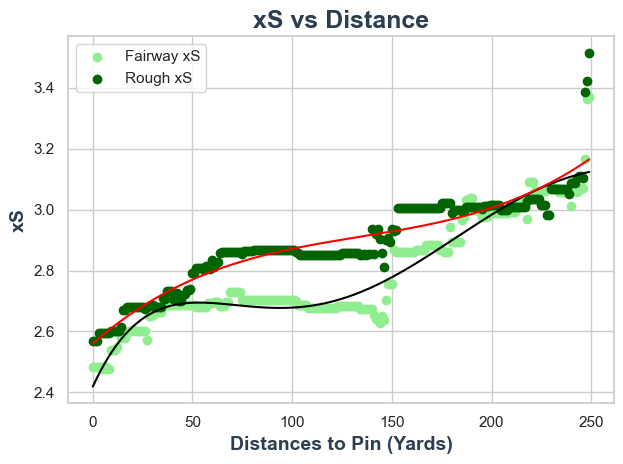

In [45]:
# Scatter plot for Fairway Predictions
plt.scatter(list_of_distances, Fairway_Predictions, color='lightgreen', label='Fairway xS')
coefficients = np.polyfit(list_of_distances, Fairway_Predictions, 5)
poly_line = np.poly1d(coefficients)
plt.plot(list_of_distances, poly_line(list_of_distances), color='black')

# Scatter plot for Rough Predictions
plt.scatter(list_of_distances, Rough_Predictions, color='darkgreen', label='Rough xS')
coefficients = np.polyfit(list_of_distances, Rough_Predictions, 3)
poly_line = np.poly1d(coefficients)
plt.plot(list_of_distances, poly_line(list_of_distances), color='red')

plt.xlabel('Distances to Pin (Yards)', fontsize=14, fontweight='bold', color='#2c3e50')  # Dark blue for the label
plt.ylabel('xS', fontsize=14, fontweight='bold', color='#2c3e50')
plt.title('xS vs Distance', fontsize=18, fontweight='bold', color='#2c3e50')  # Larger title with dark blue colo

# Show legend
plt.legend()
plt.tight_layout()


# Show the plot
plt.show()

In [46]:
# Create figure
p = figure(title="Expected Strokes",width=750, height=425)

# APPROACH
scatter_data = ColumnDataSource(data=dict(
    x=list_of_distances,
    y=Fairway_Predictions,
    y2=Rough_Predictions
))

p.scatter('x', 'y2', source=scatter_data, size=9, alpha=0.6, color= 'darkgreen', legend_label='Rough')
p.scatter('x', 'y', source=scatter_data, size=9, alpha=0.6, color='lightgreen', legend_label='Fairway')

coefficients = np.polyfit(list_of_distances, Fairway_Predictions, 3)
poly_line = np.poly1d(coefficients)
p.line(list_of_distances, poly_line(list_of_distances), color='black',line_width=3)

coefficients = np.polyfit(list_of_distances, Rough_Predictions, 3)
poly_line = np.poly1d(coefficients)
p.line(list_of_distances, poly_line(list_of_distances), color='red',line_width=3)


#STYLE
#p.title.text_font = "Helvetica"
p.xaxis.axis_label = 'Yards'
p.yaxis.axis_label = 'xS'
p.xaxis.axis_label_text_font_size = '18pt'
p.yaxis.axis_label_text_font_size = '18pt'
p.title.text_font_size = '25pt'
p.legend.location = "top_right"
p.y_range = Range1d(start = 2.47,end=3.2)  # Invert x-axis
p.x_range = Range1d(start=235, end=0)  # Invert x-axis 

# p.output_backend = "svg"
# export_svgs(p, filename="plotttt888y.svg")
# show(p)


# **Bunkers**

In [47]:
bunker_df = X_train[X_train['lie_location'] == 'Bunker']

bunker_test = bunker_df.iloc[4]

bunker_Predictions = []
list_of_bunker_distances = [round(x, 1) for x in range(7, 250)]
f = bunker_test
input = f.to_frame().T

for i in list_of_bunker_distances:
    input['distance_to_pin'] = i
    preds = stack_model.predict(input)
    bunker_Predictions.append(preds[0])


min_b = bunker_df['distance_to_pin'].min()
print(f'closest bunker shot is {min_b}')
min_b = bunker_df['distance_to_pin'].max()
print(f'furthest is {min_b}')
bunker_test


closest bunker shot is 7.194444444444445
furthest is 231.19444444444446


lie_location        Bunker
round                    4
par_value                4
slope                Level
elevation             With
lie                   Good
distance_to_pin      11.86
dist_from_center        61
distance_bins        0-100
dist_from_edge         170
Name: 6805, dtype: object

# save as svg
also put a flag at the end lol
https://stackoverflow.com/questions/34646270/how-do-i-work-with-images-in-bokeh-python


golf flag:
https://www.rawpixel.com/image/6210274/png-sticker-collage

throw in a tiger:
https://www.freepik.com/premium-psd/tiger-walking-isolated-transparent-background_45163181.htm

# get rid og 'hole' keep round and par value, add in binned distances and better ranges for each 5 shot types
# add in a range to zoom in bokeh style
# maybe start from 300 idk

In [48]:
# Create figure
p = figure(title="Expected Strokes",width=1500, height=850)

# APPROACH
scatter_data = ColumnDataSource(data=dict(
    x=list_of_distances,
    y=Fairway_Predictions,
    y2=Rough_Predictions
))
coefficients_fairway = np.polyfit(list_of_distances, Fairway_Predictions, 3)
poly_fairway = np.poly1d(coefficients_fairway)
coefficients_rough = np.polyfit(list_of_distances, Rough_Predictions, 3)
poly_rough = np.poly1d(coefficients_rough)
p.scatter('x', 'y', source=scatter_data, size=20, alpha=0.7, color=viridis(3)[1], legend_label='Fairway')
p.scatter('x', 'y2', source=scatter_data, size=20, alpha=0.7, color=viridis(3)[2], legend_label='Rough')



# OFF THE TEE
scatter_data = ColumnDataSource(data=dict(
    x=list_of_distances_tee,
    y=Tee_Predictions
))
coefficients_tee = np.polyfit(list_of_distances_tee, Tee_Predictions, 3)
poly_tee = np.poly1d(coefficients_tee)
p.scatter('x', 'y', source=scatter_data, size=20, alpha=0.4, color=viridis(3)[0], legend_label='Tee')



# PUTTING
scatter_data = ColumnDataSource(data=dict(
    xp=list_of_putting_distances,
    yp=putting_Predictions
))
p.scatter('xp', 'yp', source=scatter_data, size=20, alpha=0.4, color=viridis(5)[3], legend_label='Putting')


# #nooo sample data so bad to work with
# #BUNKER
# scatter_data = ColumnDataSource(data=dict(
#     xp=list_of_bunker_distances,
#     yp=bunker_Predictions
# ))
# p.scatter('xp', 'yp', source=scatter_data, size=20, alpha=0.4, color='red', legend_label='Bunker')



#STYLE
p.title.text_font = "Helvetica"
p.xaxis.axis_label = 'Yards to Pin'
p.yaxis.axis_label = 'xS'
p.xaxis.axis_label_text_font_size = '18pt'
p.yaxis.axis_label_text_font_size = '18pt'
p.title.text_font_size = '25pt'
p.legend.location = "top_right"
p.x_range = Range1d(start=600, end=-10)  # Invert x-axis

show(p)
# export_png(grid, filename="P2F.png")


# **Final xSG vs True Score**

In [77]:
result_df['xS'] = 0


#approach
bunker_test = bunker_df.iloc[4]
f = bunker_test
input = f.to_frame().T

#green
putting_test = putting_X_valid.iloc[9]
f = putting_test
putting_input = f.to_frame().T

for index, row in result_df.iterrows():

    if row['lie_location'] == 'Green':

        putting_input['slope'] = row['slope']
        putting_input['elevation'] = row['elevation']
        putting_input['distance_to_pin'] = row['distance_to_pin']
        putting_input['distance_bins_putting'] = row['distance_bins_putting']
        putting_input['dist_from_edge'] = row['dist_from_edge']


        preds = stack_model_putting.predict(putting_input)
        result_df['xS'].iloc[index] = preds[0]

    if row['lie_location'] != 'Green':


        input['lie_location'] = row['lie_location']
        input['round'] = row['round']
        input['par_value'] = row['par_value']
        input['slope'] = row['slope']
        input['elevation'] = row['elevation']
        input['lie'] = row['lie']
        input['distance_to_pin'] = row['distance_to_pin']
        input['dist_from_center'] = row['dist_from_center']
        input['distance_bins'] = row['distance_bins']
        input['dist_from_edge'] = row['dist_from_edge']


        preds = stack_model.predict(input)
        result_df['xS'].iloc[index] = preds[0]

result_df['xS']
result_df['SG'] = result_df['xS'] - result_df['strokes_to_hole_out']


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [95]:
# Assuming result_df contains your DataFrame and 'SG' is the column name
hist, edges = np.histogram(result_df['SG'], bins=100)

# Find the index of the bin with the maximum frequency
max_freq_index = np.argmax(hist)

# Exclude the bin with the maximum frequency
hist = np.delete(hist, max_freq_index)
edges = np.delete(edges, max_freq_index)

# Create the figure
p = figure(title='Distribution of SG', background_fill_color="#f5f5f5")

# Plot the histogram
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color=viridis_palette[180], line_color="#033649")

# Customize axes
p.xaxis.axis_label = 'SG'
p.yaxis.axis_label = 'Frequency'

# Add grid lines
p.xgrid.grid_line_color = None
p.ygrid.grid_line_alpha = 0.6
p.x_range.start = -1
p.x_range.end = 1

show(p)


In [96]:
result_df.to_csv('SG_golf.csv')

# Bin:

- putting
- [0,50] - rough and fairway for both
- [50,100] - rough and fairway for both
- [100,150] - rough and fairway for both
- [150, 200] - rough and fairway for both
- [200+] - rough and fairway for both
- Tee

# test before bin

In [97]:
result_df

,player_id,last_name,round,hole,hole_score,par_value,yardage,shot,shot_type,num_of_strokes,...,lie_location,round_hole_combination,strokes_to_hole_out,flag_strokes_to_hole_out_1_or_less,flag_water_or_unknown_lies,flag_non_standard_shot_types,distance_bins,distance_bins_putting,xS,SG
0,1810,Mickelson,1,1,4,4,424,1,S,1,...,Tee,1,4,False,False,False,400-500,,3.90,-0.10
1,1810,Mickelson,1,1,4,4,424,2,S,1,...,Rough,1,3,False,False,False,100-200,,3.09,0.09
2,1810,Mickelson,1,1,4,4,424,3,S,1,...,Green,1,2,False,False,False,0-100,6-14,2.02,0.02
3,1810,Mickelson,1,1,4,4,424,4,S,1,...,Green,1,1,False,False,False,0-100,1-1.5,1.00,0.00
4,1810,Mickelson,1,2,2,3,214,1,S,1,...,Tee,2,2,False,False,False,200-300,,2.86,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8062,33141,Bradley,4,17,5,4,470,4,S,1,...,Green,71,2,False,False,False,0-100,14-30,2.08,0.08
8063,33141,Bradley,4,17,5,4,470,5,S,1,...,Green,71,1,False,False,False,0-100,1.5-2,1.02,0.02
8064,33141,Bradley,4,18,3,3,235,1,S,1,...,Tee,72,3,False,False,False,200-300,,3.06,0.06
8065,33141,Bradley,4,18,3,3,235,2,S,1,...,Green,72,2,False,False,False,0-100,6-14,2.02,0.02


In [116]:
result_df['last_name'].unique()

array(['Mickelson', 'Toms', 'Stricker', 'Singh', 'Senden', 'Jacobson',
       'Wilson', 'Howell III', 'Ogilvy', 'Baddeley', 'Rose', 'Kuchar',
       'Van Pelt', 'Donald', 'Choi', 'Scott', 'Yang', 'Mahan', 'Haas',
       'Byrd', 'Dufner', 'Watson', 'Reavie', 'Watney', 'Snedeker', 'Day',
       'Simpson', 'Johnson', 'Woodland', 'Bradley'], dtype=object)

In [162]:
Mickelson_df = result_df[result_df['last_name'] == 'Baddeley']
Mickelson_df.groupby('lie_location')['SG'].sum()

lie_location
Bunker     0.57
Fairway    5.80
Green     -0.83
Rough      5.76
Tee        9.45
Name: SG, dtype: float64

In [163]:
Mickelson_df.groupby('lie_location')['SG'].mean()

lie_location
Bunker     0.05
Fairway    0.17
Green     -0.01
Rough      0.14
Tee        0.14
Name: SG, dtype: float64

<Axes: xlabel='SG', ylabel='Density'>

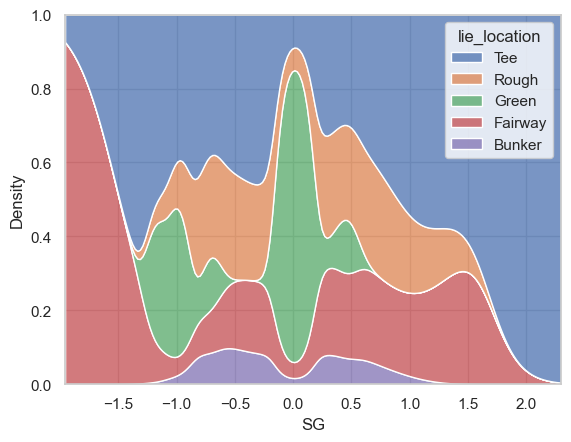

In [164]:
sns.kdeplot(data=Mickelson_df, x="SG", hue="lie_location", multiple="fill")


<Axes: xlabel='SG', ylabel='Density'>

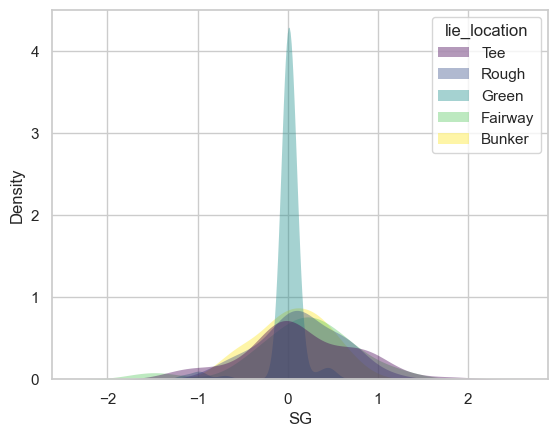

In [165]:
sns.kdeplot(
   data=Mickelson_df, x="SG", hue="lie_location",
   fill=True, common_norm=False, palette=viridis(5),
   alpha=.4, linewidth=0,
)

In [166]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.transform import factor_cmap
from bokeh.models import Legend
from bokeh.palettes import Viridis
from scipy.stats import gaussian_kde
import numpy as np

# Create a Bokeh figure
p = figure(title="Density Plot of SG by Lie Location", background_fill_color="#fafafa")

# Define colors
colors = factor_cmap('lie_location', palette=Viridis[5], factors=Mickelson_df['lie_location'].unique())

# Define x range based on data
x_range = (min(Mickelson_df['SG']), max(Mickelson_df['SG']))

# Iterate over unique lie locations
for i, lie_loc in enumerate(Mickelson_df['lie_location'].unique()):
    # Filter data for the current lie location
    subset = Mickelson_df[Mickelson_df['lie_location'] == lie_loc]['SG']
    
    # Perform Kernel Density Estimation
    kde = gaussian_kde(subset)
    x = np.linspace(min(subset), max(subset), 100)
    y = kde(x)
    
    # Plot KDE
    p.line(x, y, line_width=2, legend_label=lie_loc, color=Viridis[5][i])

    #p.patch(np.append(x, x[::-1]), np.append(y, np.zeros_like(y[::-1])), color=Viridis[5][i], alpha=0.4, line_color=None)


# Add legend
legend = Legend(items=[(lie_loc, [p.renderers[i]]) for i, lie_loc in enumerate(Mickelson_df['lie_location'].unique())])
p.add_layout(legend)

# Customize plot
p.xaxis.axis_label = 'SG'
p.yaxis.axis_label = 'Density'
p.x_range.start, p.x_range.end = x_range

# Show plot
output_notebook()
show(p)


Loading BokehJS ...

# **Bin BY 50, putting, and oof the tee, THEN CALL IT A PROJECT AFTER HOLE LOCATION CHARTS**